In [17]:
!pip install ucimlrepo

# Import Libraries

from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import warnings
warnings.filterwarnings('ignore')

# Data

df_obj = fetch_ucirepo(id=544)
X = df_obj.data.features
y = df_obj.data.targets

df = pd.concat([X, y], axis=1)

print("Dataset Shape:", df.shape)
print("\nTarget Distribution:")
print(df['NObeyesdad'].value_counts())
print("\nMissing Values:")
print(df.isnull().sum().sum(), "missing values found")

df.head()

# Feature Engineering
df_engineered = df.copy()

# Age groups
df_engineered['Age_Group'] = pd.cut(df_engineered['Age'],
                                     bins=[0, 20, 30, 40, 100],
                                     labels=['Teen', 'Young', 'Middle', 'Senior'])

Dataset Shape: (2111, 17)

Target Distribution:
NObeyesdad
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: count, dtype: int64

Missing Values:
0 missing values found


In [18]:
# Preprocessing

X_eng = df_engineered.drop('NObeyesdad', axis=1)
y_target = df_engineered['NObeyesdad']

categorical_cols = ['Gender', 'CAEC', 'CALC', 'MTRANS', 'Age_Group']
binary_cols = ['family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
numeric_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

X_eng[binary_cols] = X_eng[binary_cols].replace({'yes': 1, 'no': 0})

preprocessor = make_column_transformer(
    (OneHotEncoder(drop='first', sparse_output=False), categorical_cols),
    (StandardScaler(), numeric_cols),
    remainder='passthrough'
)

X_preprocessed = preprocessor.fit_transform(X_eng)

feature_names = (
    preprocessor.named_transformers_['onehotencoder']
    .get_feature_names_out(categorical_cols).tolist()
    + numeric_cols
    + binary_cols
)

X_df = pd.DataFrame(X_preprocessed, columns=feature_names)

le = LabelEncoder()
y_encoded = le.fit_transform(y_target)

print(f"\nPreprocessed shape: {X_df.shape}")
print(f"Number of features: {len(feature_names)}")
print("\nTarget encoding:")
for cls, encoded in zip(le.classes_, range(len(le.classes_))):
    print(f"  {cls}: {encoded}")


Preprocessed shape: (2111, 26)
Number of features: 26

Target encoding:
  Insufficient_Weight: 0
  Normal_Weight: 1
  Obesity_Type_I: 2
  Obesity_Type_II: 3
  Obesity_Type_III: 4
  Overweight_Level_I: 5
  Overweight_Level_II: 6


In [19]:
custom_order = {
    'Insufficient_Weight': 0,
    'Normal_Weight': 1,
    'Overweight_Level_I': 2,
    'Overweight_Level_II': 3,
    'Obesity_Type_I': 4,
    'Obesity_Type_II': 5,
    'Obesity_Type_III': 6
}
y_encoded = df_engineered['NObeyesdad'].map(custom_order)

In [20]:
feature_names.remove("Age")
feature_names.remove("Weight")

X_df = X_df.drop(columns=['Age', 'Weight'])

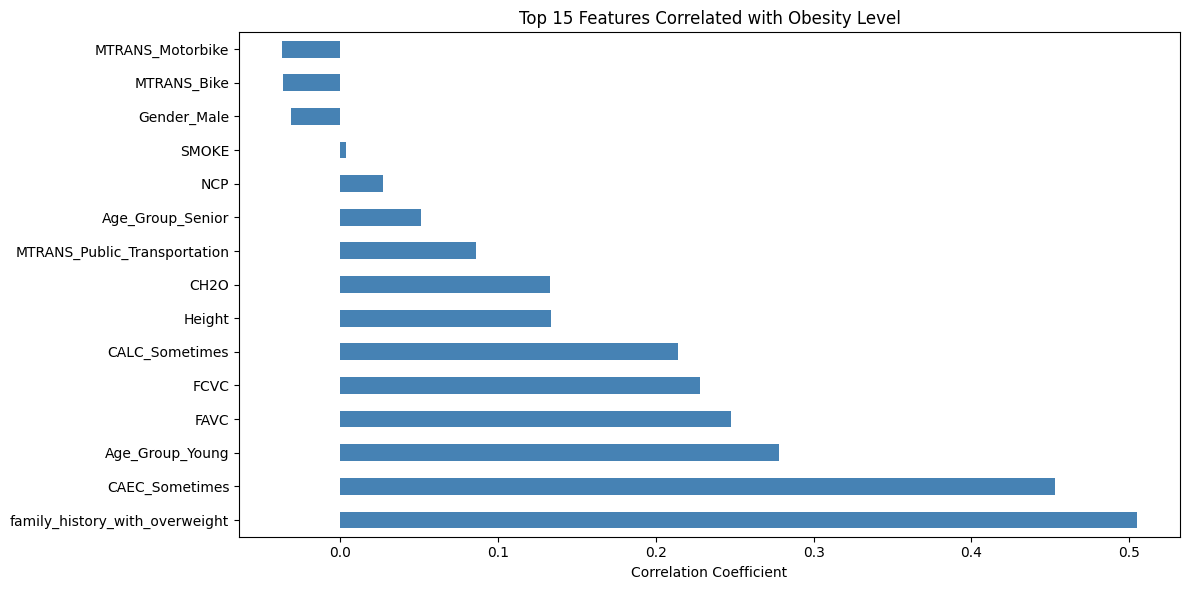


Top 10 Most Correlated Features:
family_history_with_overweight    0.505148
CAEC_Sometimes                    0.453188
Age_Group_Young                   0.277878
FAVC                              0.247793
FCVC                              0.227759
CALC_Sometimes                    0.214067
Height                            0.133565
CH2O                              0.133008
MTRANS_Public_Transportation      0.085606
Age_Group_Senior                  0.050954
Name: Target, dtype: float64


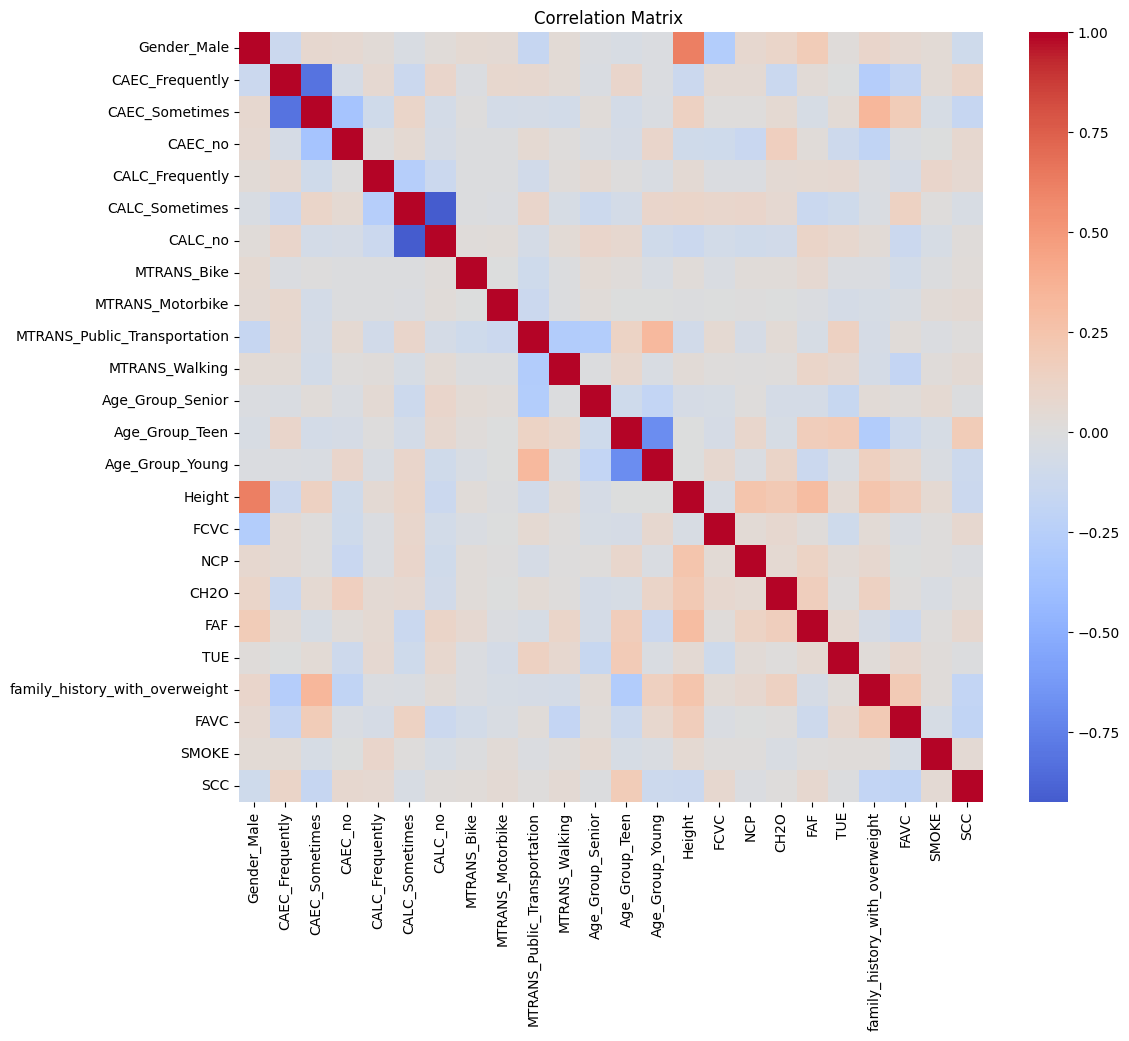

In [21]:
# Feature Correlations

full_df = X_df.copy()
full_df['Target'] = y_encoded

correlations = full_df.corr()['Target'].drop('Target').sort_values(ascending=False)

plt.figure(figsize=(12, 6))
top_n = 15
correlations.head(top_n).plot(kind='barh', color='steelblue')
plt.title(f'Top {top_n} Features Correlated with Obesity Level')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

print("\nTop 10 Most Correlated Features:")
print(correlations.head(10))

import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix
corr_matrix = full_df.drop(columns=["Target"]).corr()

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.title("Correlation Matrix ")
plt.show()

In [22]:
# Train-Test Split



X_train, X_test, y_train, y_test = train_test_split(
    X_df, y_encoded, test_size=0.2, random_state=1, stratify=y_encoded
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Logistic Regression

log_reg = LogisticRegression(max_iter=1000, multi_class='multinomial',
                             class_weight='balanced', random_state=1)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

accuracy_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')

print("Logistic Regression Results")
print(f"Accuracy: {accuracy_lr:.4f}")
print(f"F1 Score: {f1_lr:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=le.classes_))

Training set: (1688, 24)
Test set: (423, 24)
Logistic Regression Results
Accuracy: 0.6052
F1 Score: 0.5883

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.60      0.67      0.63        54
      Normal_Weight       0.45      0.43      0.44        58
     Obesity_Type_I       0.51      0.40      0.45        58
    Obesity_Type_II       0.57      0.28      0.37        58
   Obesity_Type_III       0.56      0.50      0.53        70
 Overweight_Level_I       0.53      0.93      0.67        60
Overweight_Level_II       0.97      1.00      0.98        65

           accuracy                           0.61       423
          macro avg       0.60      0.60      0.58       423
       weighted avg       0.60      0.61      0.59       423



In [23]:
# KNN with Tuning

print("\nTuning KNN hyperparameters...")
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_grid = GridSearchCV(KNeighborsClassifier(), param_grid,
                        cv=5, scoring='accuracy', n_jobs=-1)
knn_grid.fit(X_train, y_train)

print(f"Best parameters: {knn_grid.best_params_}")
print(f"Best cross-validation score: {knn_grid.best_score_:.4f}")

best_knn = knn_grid.best_estimator_
y_pred_knn = best_knn.predict(X_test)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')

print("KNN Results")
print(f"Accuracy: {accuracy_knn:.4f}")
print(f"F1 Score: {f1_knn:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn, target_names=le.classes_))


Tuning KNN hyperparameters...
Best parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Best cross-validation score: 0.8104
KNN Results
Accuracy: 0.8345
F1 Score: 0.8282

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.77      0.89      0.83        54
      Normal_Weight       0.78      0.50      0.61        58
     Obesity_Type_I       0.84      0.84      0.84        58
    Obesity_Type_II       0.83      0.78      0.80        58
   Obesity_Type_III       0.81      0.87      0.84        70
 Overweight_Level_I       0.80      0.93      0.86        60
Overweight_Level_II       0.97      1.00      0.98        65

           accuracy                           0.83       423
          macro avg       0.83      0.83      0.82       423
       weighted avg       0.83      0.83      0.83       423



Decision Tree Results
Accuracy: 0.7116
F1 Score: 0.7101

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.70      0.74      0.72        54
      Normal_Weight       0.55      0.60      0.57        58
     Obesity_Type_I       0.59      0.50      0.54        58
    Obesity_Type_II       0.57      0.59      0.58        58
   Obesity_Type_III       0.69      0.64      0.67        70
 Overweight_Level_I       0.85      0.88      0.87        60
Overweight_Level_II       0.98      1.00      0.99        65

           accuracy                           0.71       423
          macro avg       0.71      0.71      0.71       423
       weighted avg       0.71      0.71      0.71       423



<Figure size 1200x600 with 0 Axes>

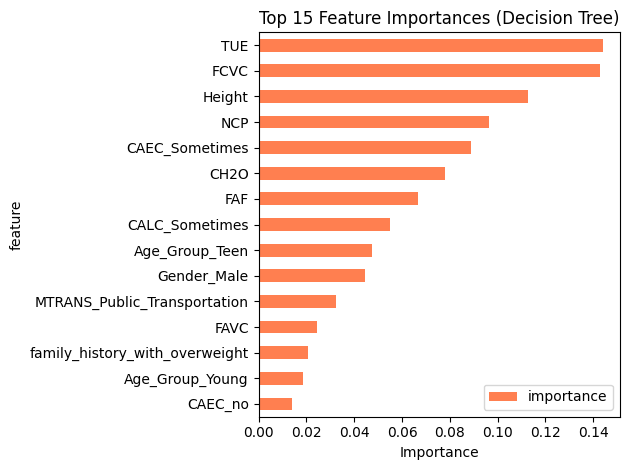

In [24]:
# Decision Tree

dt = DecisionTreeClassifier(max_depth=10, min_samples_split=10,
                           min_samples_leaf=5, class_weight='balanced',
                           random_state=1)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

accuracy_dt = accuracy_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt, average='weighted')

print("Decision Tree Results")
print(f"Accuracy: {accuracy_dt:.4f}")
print(f"F1 Score: {f1_dt:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt, target_names=le.classes_))

# Feature importance for Decision Tree
feature_importance_dt = pd.DataFrame({
    'feature': feature_names,
    'importance': dt.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
feature_importance_dt.head(15).plot(x='feature', y='importance', kind='barh', color='coral')
plt.title('Top 15 Feature Importances (Decision Tree)')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Random Forest Results
Accuracy: 0.8629
F1 Score: 0.8650

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.94      0.85      0.89        54
      Normal_Weight       0.64      0.86      0.74        58
     Obesity_Type_I       0.89      0.81      0.85        58
    Obesity_Type_II       0.92      0.81      0.86        58
   Obesity_Type_III       0.87      0.76      0.81        70
 Overweight_Level_I       0.88      0.95      0.91        60
Overweight_Level_II       0.98      1.00      0.99        65

           accuracy                           0.86       423
          macro avg       0.87      0.86      0.86       423
       weighted avg       0.88      0.86      0.86       423



<Figure size 1200x600 with 0 Axes>

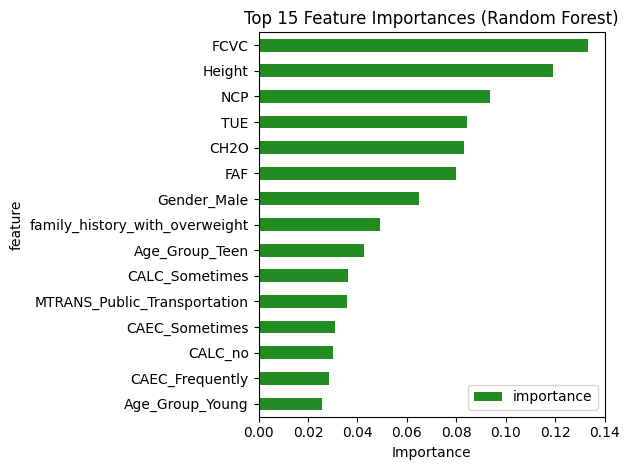

In [25]:
# Random Forest

rf = RandomForestClassifier(n_estimators=200, max_depth=20,
                           min_samples_split=5, class_weight='balanced',
                           random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

print("Random Forest Results")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
feature_importance.head(15).plot(x='feature', y='importance', kind='barh', color='forestgreen')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [26]:
# Gradient Boosting

gb = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1,
                                max_depth=5, random_state=1)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

accuracy_gb = accuracy_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb, average='weighted')

print("Gradient Boosting Results")
print(f"Accuracy: {accuracy_gb:.4f}")
print(f"F1 Score: {f1_gb:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb, target_names=le.classes_))

Gradient Boosting Results
Accuracy: 0.8463
F1 Score: 0.8474

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.92      0.85      0.88        54
      Normal_Weight       0.64      0.79      0.71        58
     Obesity_Type_I       0.79      0.76      0.77        58
    Obesity_Type_II       0.81      0.72      0.76        58
   Obesity_Type_III       0.89      0.80      0.84        70
 Overweight_Level_I       0.91      1.00      0.95        60
Overweight_Level_II       1.00      0.98      0.99        65

           accuracy                           0.85       423
          macro avg       0.85      0.84      0.84       423
       weighted avg       0.85      0.85      0.85       423



In [27]:
# Support Vector Machine

print("\nTraining SVM (this may take a moment)...")
svm = SVC(kernel='rbf', C=10, gamma='scale', class_weight='balanced', random_state=1)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')

print("SVM Results")
print(f"Accuracy: {accuracy_svm:.4f}")
print(f"F1 Score: {f1_svm:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))


Training SVM (this may take a moment)...
SVM Results
Accuracy: 0.8180
F1 Score: 0.8182

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.81      0.89      0.85        54
      Normal_Weight       0.58      0.66      0.62        58
     Obesity_Type_I       0.79      0.72      0.76        58
    Obesity_Type_II       0.80      0.71      0.75        58
   Obesity_Type_III       0.85      0.83      0.84        70
 Overweight_Level_I       0.90      0.90      0.90        60
Overweight_Level_II       0.97      1.00      0.98        65

           accuracy                           0.82       423
          macro avg       0.82      0.81      0.81       423
       weighted avg       0.82      0.82      0.82       423



Model Comparision
                     accuracy        f1
Random Forest        0.862884  0.864966
Gradient Boosting    0.846336  0.847434
KNN                  0.834515  0.828159
SVM                  0.817967  0.818189
Decision Tree        0.711584  0.710076
Logistic Regression  0.605201  0.588349


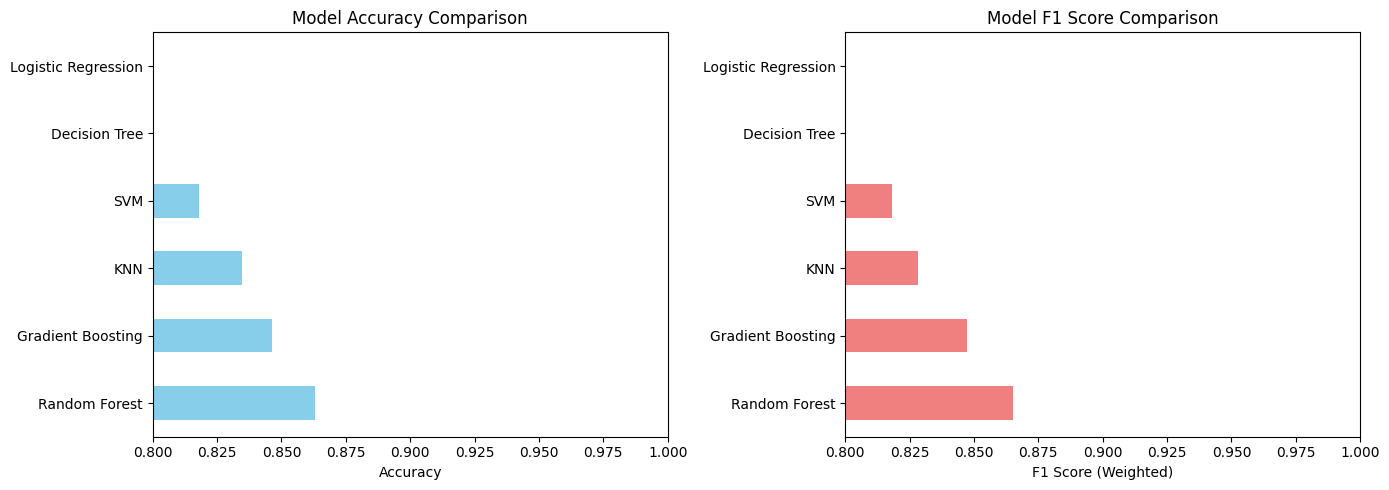

In [28]:
# Model Comparison

results = {
    'Logistic Regression': {'accuracy': accuracy_lr, 'f1': f1_lr},
    'KNN': {'accuracy': accuracy_knn, 'f1': f1_knn},
    'Decision Tree': {'accuracy': accuracy_dt, 'f1': f1_dt},
    'Random Forest': {'accuracy': accuracy_rf, 'f1': f1_rf},
    'Gradient Boosting': {'accuracy': accuracy_gb, 'f1': f1_gb},
    'SVM': {'accuracy': accuracy_svm, 'f1': f1_svm}
}

results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('accuracy', ascending=False)

print("Model Comparision")
print(results_df.to_string())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

results_df['accuracy'].plot(kind='barh', ax=axes[0], color='skyblue')
axes[0].set_xlabel('Accuracy')
axes[0].set_title('Model Accuracy Comparison')
axes[0].set_xlim([0.8, 1.0])

results_df['f1'].plot(kind='barh', ax=axes[1], color='lightcoral')
axes[1].set_xlabel('F1 Score (Weighted)')
axes[1].set_title('Model F1 Score Comparison')
axes[1].set_xlim([0.8, 1.0])

plt.tight_layout()
plt.show()

In [29]:
# Cross-Validation Analysis

print("5-fold Cross Validation")

models_cv = {
    'Logistic Regression': log_reg,
    'KNN': best_knn,
    'Decision Tree': dt,
    'Random Forest': rf,
    'Gradient Boosting': gb,
    'SVM': svm
}

cv_results = {}
for name, model in models_cv.items():
    scores = cross_val_score(model, X_df, y_encoded, cv=5, scoring='accuracy')
    cv_results[name] = scores
    print(f"\n{name}:")
    print(f"  Mean: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
    print(f"  Scores: {scores}")

5-fold Cross Validation

Logistic Regression:
  Mean: 0.5965 (+/- 0.1287)
  Scores: [0.47754137 0.66350711 0.58767773 0.63507109 0.61848341]

KNN:
  Mean: 0.8219 (+/- 0.1298)
  Scores: [0.69503546 0.8507109  0.8436019  0.84123223 0.87914692]

Decision Tree:
  Mean: 0.6893 (+/- 0.1923)
  Scores: [0.5035461  0.7464455  0.69194313 0.73696682 0.76777251]

Random Forest:
  Mean: 0.8533 (+/- 0.2744)
  Scores: [0.57919622 0.91706161 0.92180095 0.91469194 0.93364929]

Gradient Boosting:
  Mean: 0.8324 (+/- 0.2764)
  Scores: [0.55791962 0.91232227 0.88151659 0.88625592 0.92417062]

SVM:
  Mean: 0.8187 (+/- 0.2044)
  Scores: [0.61465721 0.86966825 0.85781991 0.87440758 0.87677725]


In [30]:
"""# Hyperparameter Tuning - Random Forest"""

param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 15, 20, 30],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced']
}

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=1, n_jobs=-1)

rand_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=25,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2,
    random_state=1
)

rand_search.fit(X_train, y_train)

print("Best Hyperparameters:")
print(rand_search.best_params_)

print("\nBest CV Weighted F1 Score:")
print(rand_search.best_score_)

best_rf = rand_search.best_estimator_

y_pred = best_rf.predict(X_test)

print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("Test Weighted F1:", f1_score(y_test, y_pred, average='weighted'))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Hyperparameters:
{'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 20, 'class_weight': 'balanced'}

Best CV Weighted F1 Score:
0.8604175914345159

Test Accuracy: 0.8770685579196218
Test Weighted F1: 0.8778149757063998

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.92      0.85      0.88        54
      Normal_Weight       0.70      0.88      0.78        58
     Obesity_Type_I       0.90      0.79      0.84        58
    Obesity_Type_II       0.89      0.84      0.87        58
   Obesity_Type_III       0.89      0.80      0.84        70
 Overweight_Level_I       0.89      0.97      0.93        60
Overweight_Level_II       0.98      1.00      0.99        65

           accuracy                           0.88       423
          macro avg       0.88      0.88      0.88       423
       weighted avg       0.88      0.88      0.88       423



In [31]:
"""# Hyperparameter Tuning-Gradient Boosting"""

param_grid_gb = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [4, 5, 6]
}

from sklearn.model_selection import GridSearchCV

gb = GradientBoostingClassifier(random_state=1)

gb_grid = GridSearchCV(
    estimator=gb,
    param_grid=param_grid_gb,
    scoring='f1_weighted',
    cv=3,
    n_jobs=-1,
    verbose=2
)

gb_grid.fit(X_train, y_train)

print("Best Parameters:", gb_grid.best_params_)
print("Best CV Weighted F1:", gb_grid.best_score_)

best_gb = gb_grid.best_estimator_

y_pred_gb = best_gb.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred_gb))
print("Weighted F1:", f1_score(y_test, y_pred_gb, average='weighted'))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb, target_names=le.classes_))

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 150}
Best CV Weighted F1: 0.8312718116291808

Accuracy: 0.8463356973995272
Weighted F1: 0.8473869735808063

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.90      0.87      0.89        54
      Normal_Weight       0.63      0.78      0.70        58
     Obesity_Type_I       0.81      0.74      0.77        58
    Obesity_Type_II       0.81      0.76      0.79        58
   Obesity_Type_III       0.90      0.80      0.85        70
 Overweight_Level_I       0.89      0.98      0.94        60
Overweight_Level_II       0.98      0.98      0.98        65

           accuracy                           0.85       423
          macro avg       0.85      0.84      0.84       423
       weighted avg       0.85      0.85      0.85       423



                           Feature  Importance
15                            FCVC    0.170251
14                          Height    0.136840
19                             TUE    0.134117
17                            CH2O    0.074897
18                             FAF    0.074661
16                             NCP    0.072951
0                      Gender_Male    0.060635
12                  Age_Group_Teen    0.058244
20  family_history_with_overweight    0.037817
2                   CAEC_Sometimes    0.031072
1                  CAEC_Frequently    0.027987
9     MTRANS_Public_Transportation    0.020176
21                            FAVC    0.018254
5                   CALC_Sometimes    0.015760
13                 Age_Group_Young    0.011549


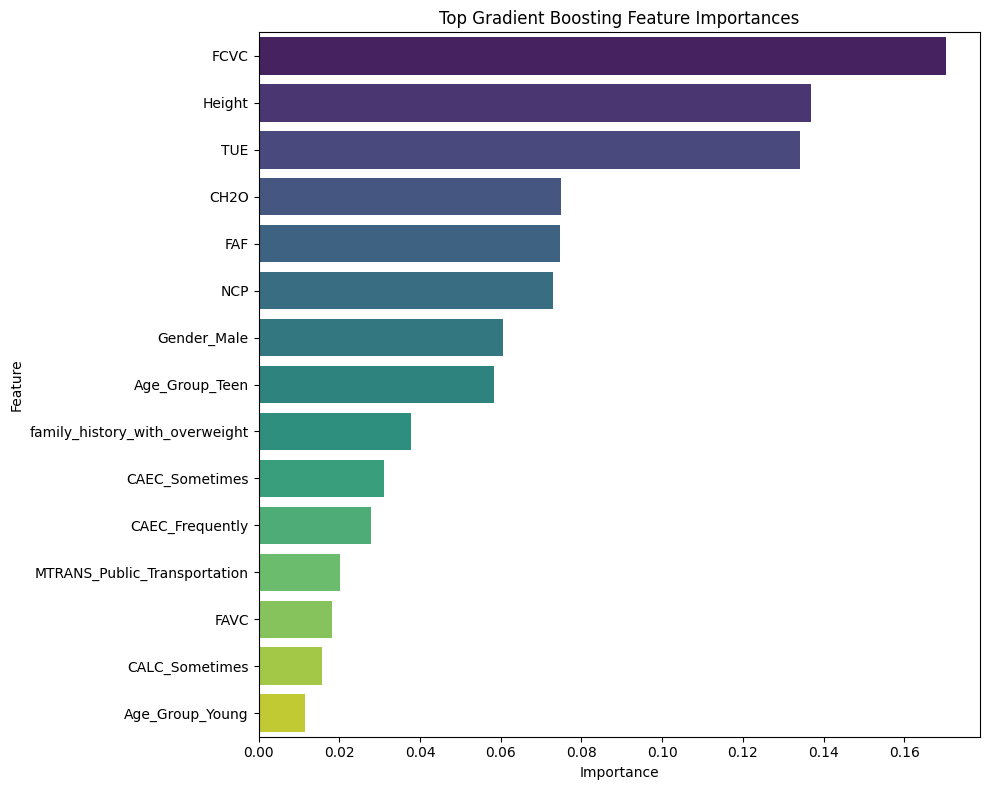

In [32]:
import numpy as np
import pandas as pd

importances = best_gb.feature_importances_
feature_importance_df = pd.DataFrame({
    "Feature": X_df.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print(feature_importance_df.head(15))

plt.figure(figsize=(10, 8))
sns.barplot(
    data=feature_importance_df.head(15),
    x="Importance",
    y="Feature",
    palette="viridis"
)
plt.title("Top Gradient Boosting Feature Importances")
plt.tight_layout()
plt.show()